# Práctico 02: Anáslisis Exploratorio y Curación - Resolución

## Importar librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Opción para ver todas las columnas del dataset en el notebook
pd.set_option('display.max_columns', 50)

In [4]:
df = pd.read_csv('../data.csv', sep = ";")
df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Análisis de las variables

### Valores nulos

In [5]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### Outliers

[Text(0.5, 0, 'cons.conf.idx sin outliers')]

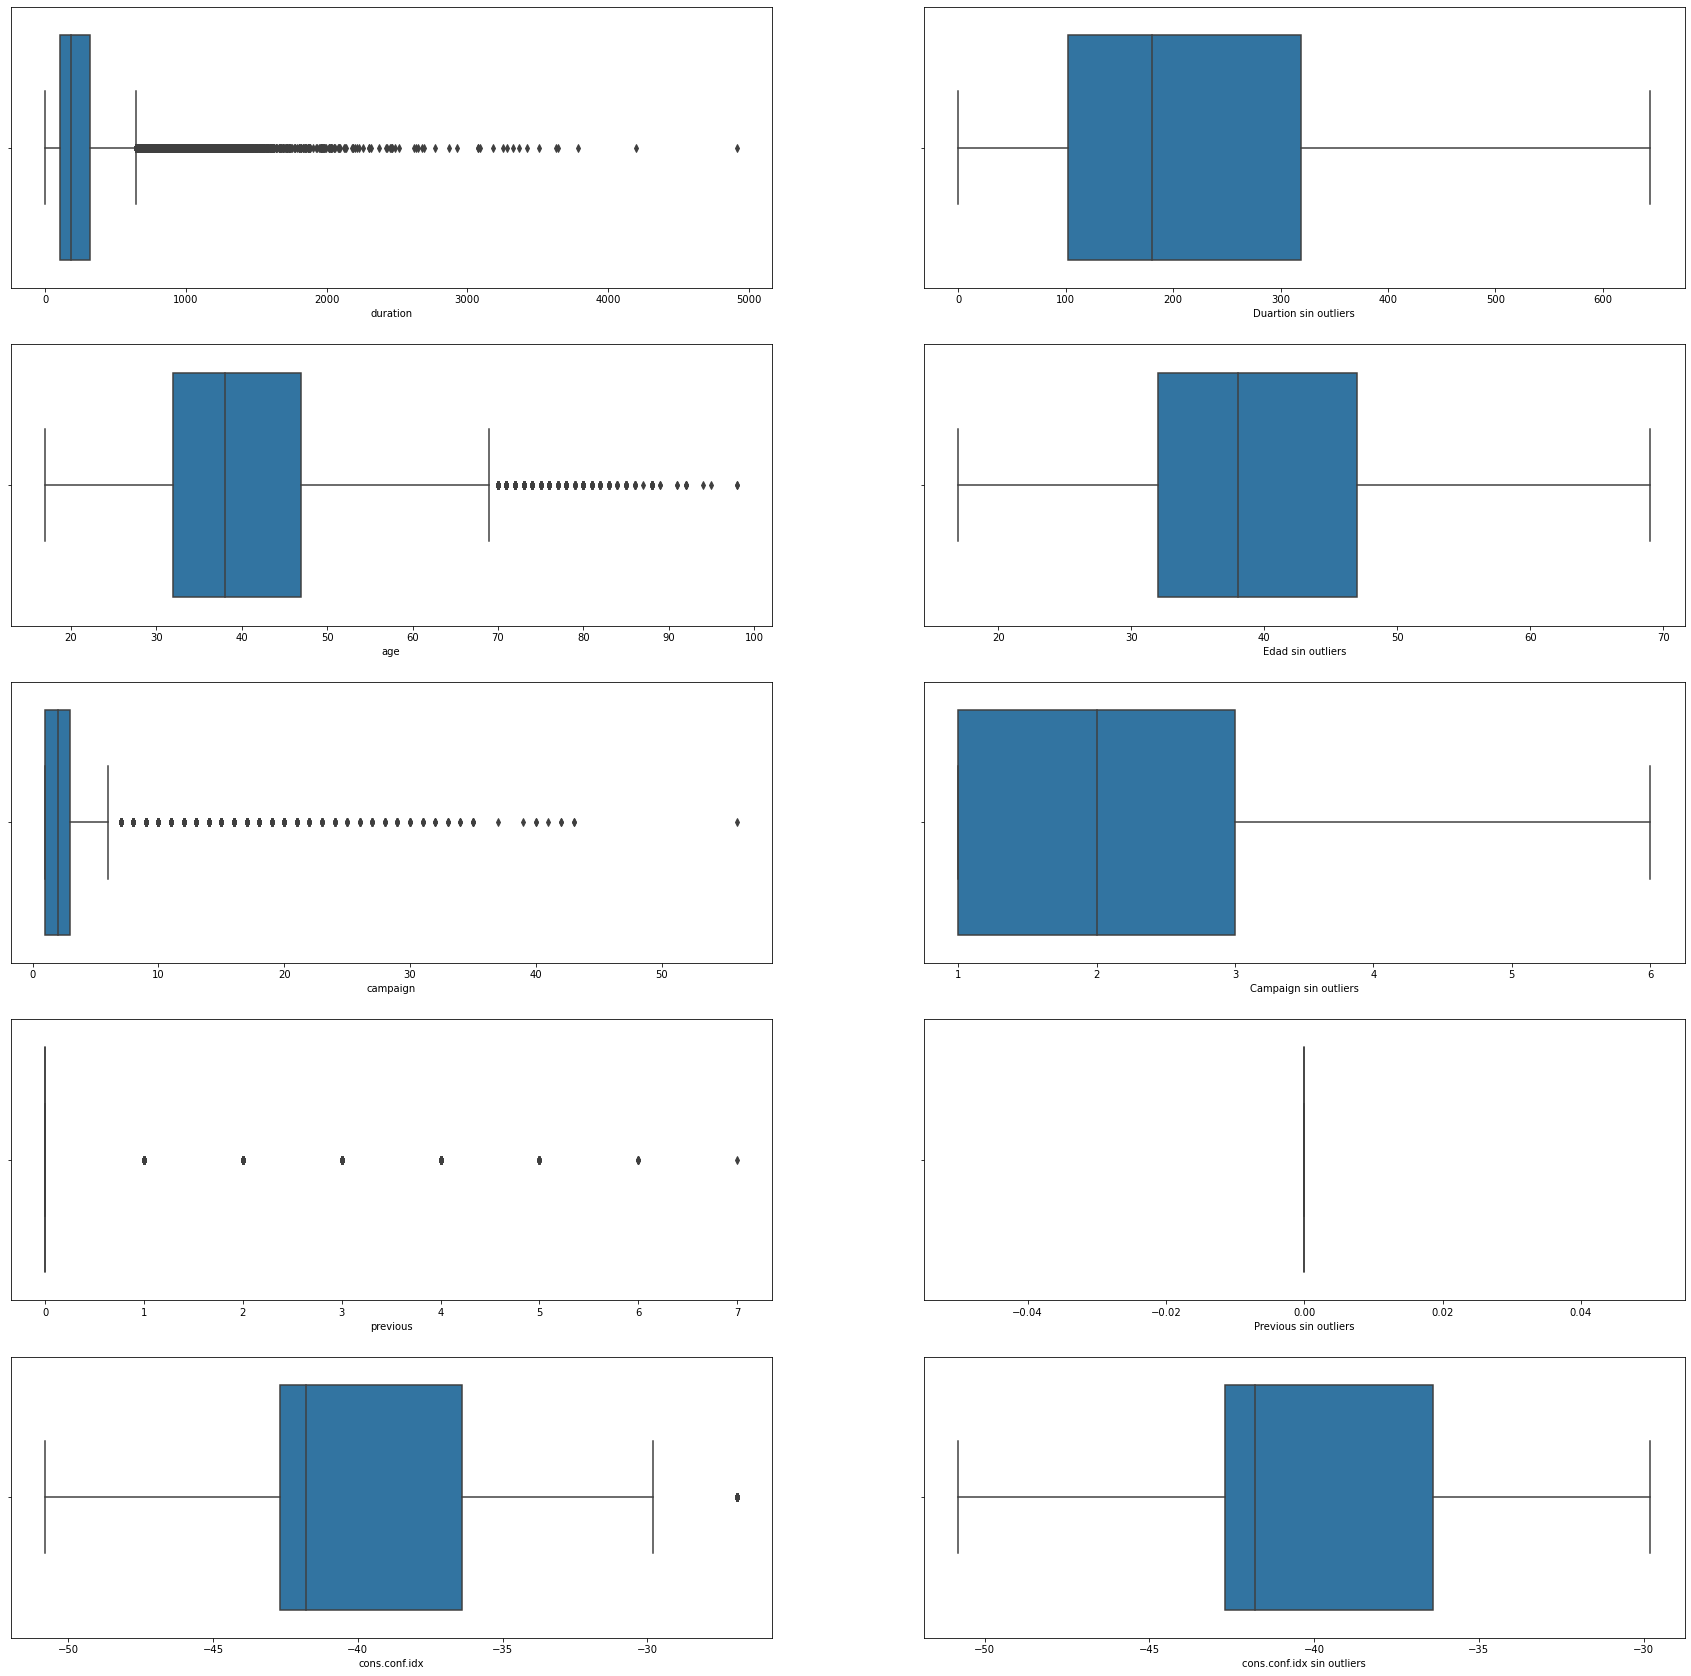

In [7]:
fig, axs = plt.subplots(nrows=5,ncols=2, figsize=(30,30))

sns.boxplot(data=df, x='duration', ax=axs[0,0])
sns.boxplot(data=df, x='duration', showfliers=False, ax=axs[0,1]).set(xlabel='Duartion sin outliers')

sns.boxplot(data=df, x='age', ax=axs[1,0])
sns.boxplot(data=df, x='age', showfliers=False, ax=axs[1,1]).set(xlabel='Edad sin outliers')

sns.boxplot(data=df, x='campaign', ax=axs[2,0])
sns.boxplot(data=df, x='campaign', showfliers=False, ax=axs[2,1]).set(xlabel='Campaign sin outliers')

sns.boxplot(data=df, x='previous', ax=axs[3,0])
sns.boxplot(data=df, x='previous', showfliers=False, ax=axs[3,1]).set(xlabel='Previous sin outliers')

sns.boxplot(data=df, x='cons.conf.idx', ax=axs[4,0])
sns.boxplot(data=df, x='cons.conf.idx', showfliers=False, ax=axs[4,1]).set(xlabel='cons.conf.idx sin outliers')

### Distribuciones de las variables numéricas

<AxesSubplot:xlabel='nr.employed', ylabel='Count'>

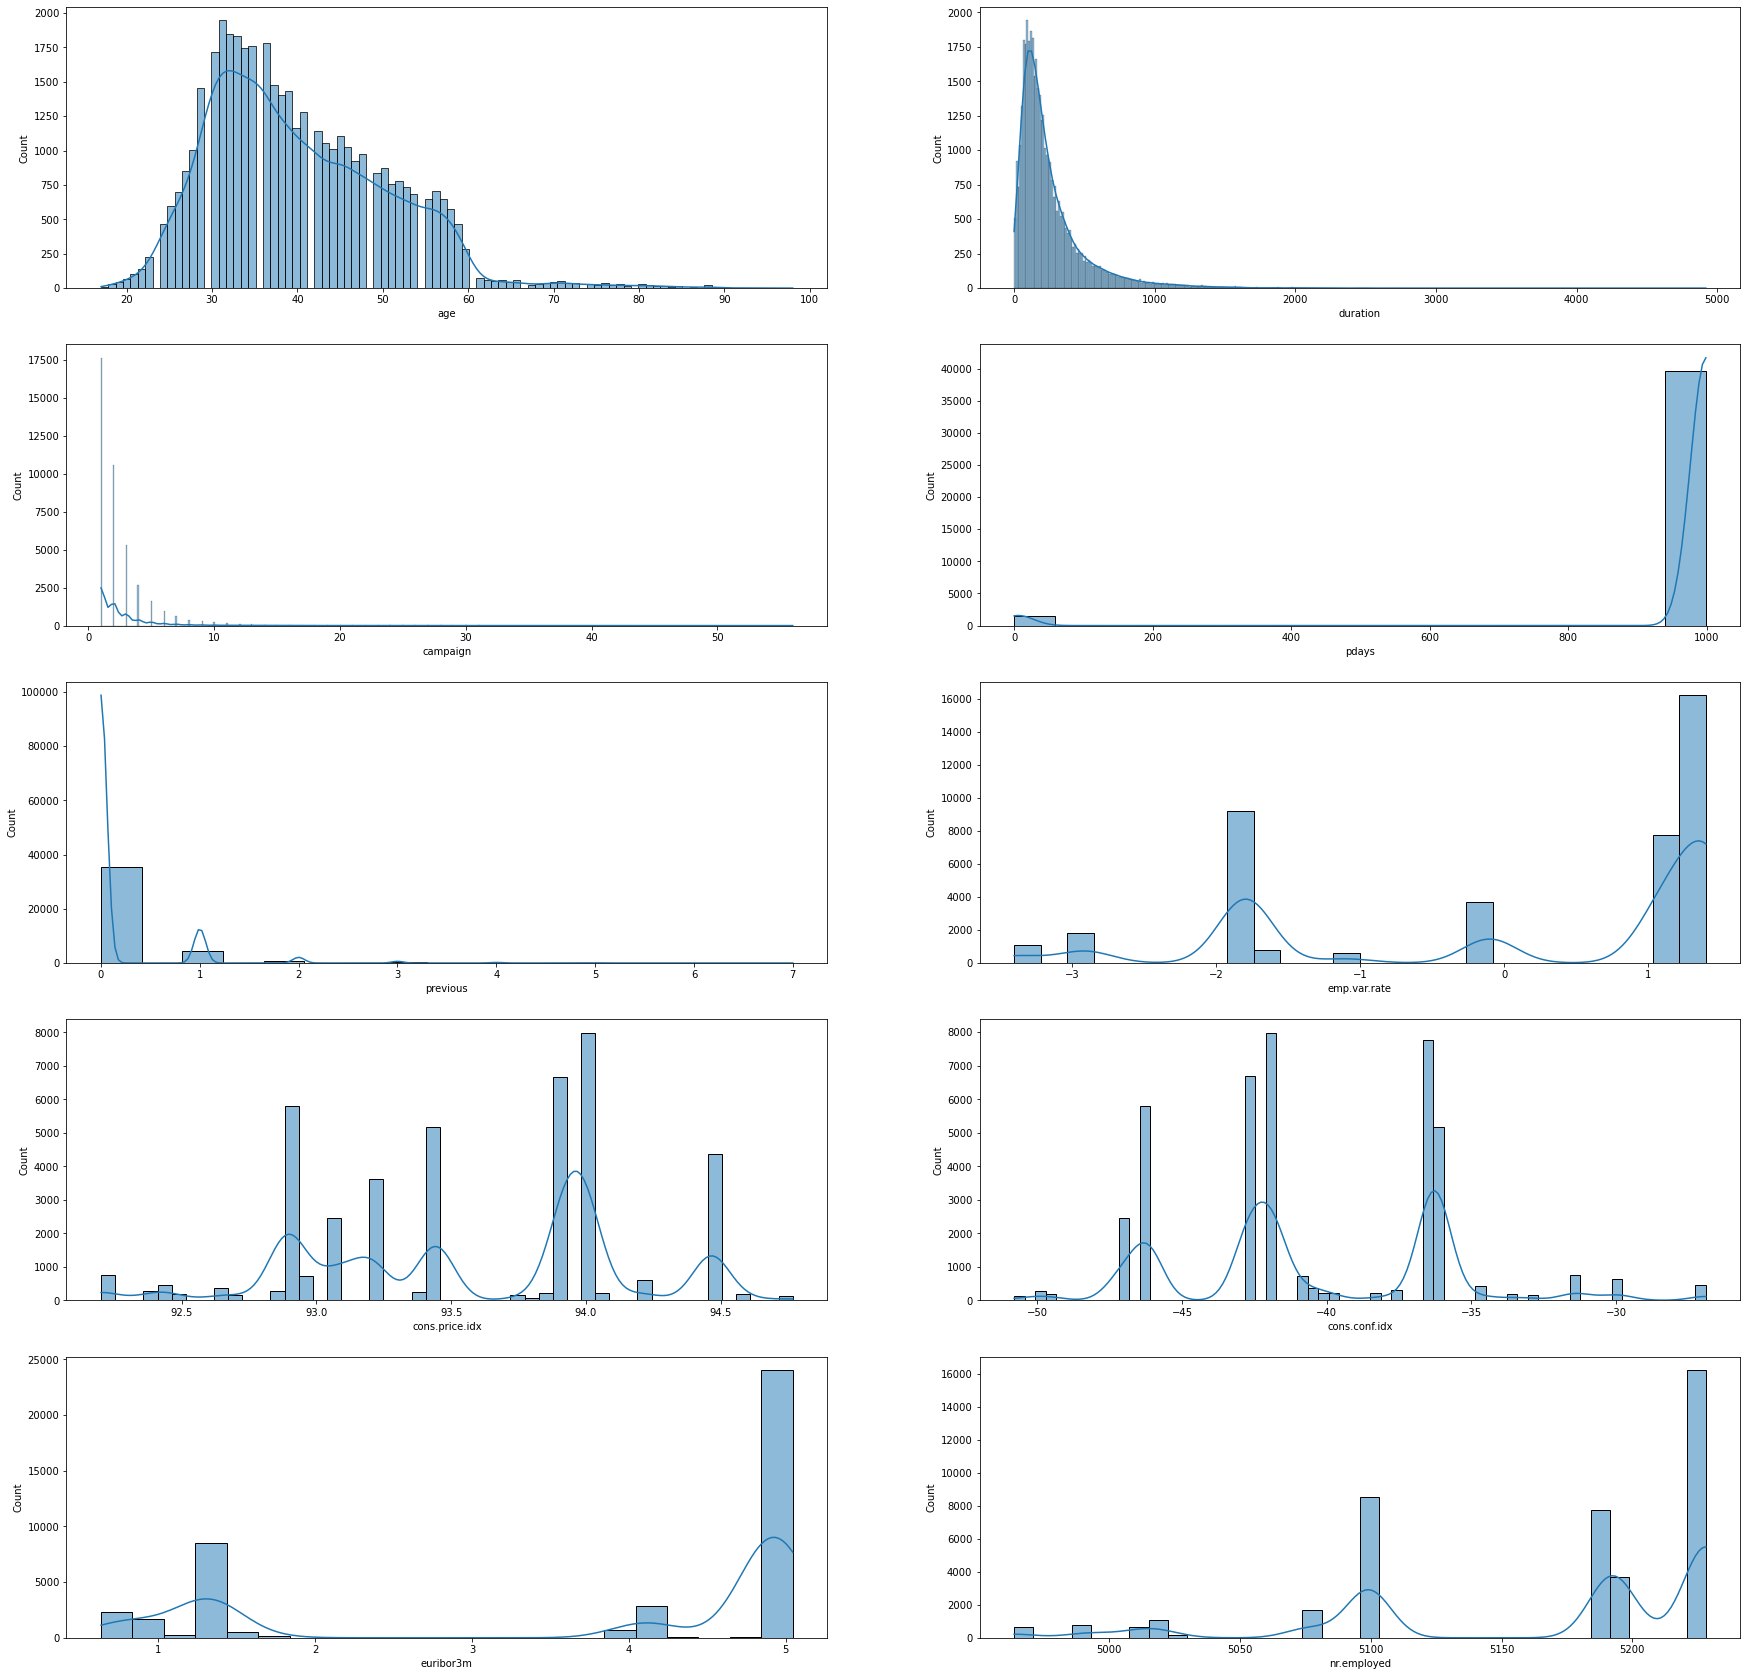

In [12]:
fig, axs = plt.subplots(nrows=5,ncols=2, figsize=(30,30))

sns.histplot(data=df, x='age', kde=True, ax=axs[0,0])
sns.histplot(data=df, x='duration', kde=True, ax=axs[0,1])
sns.histplot(data=df, x='campaign', kde=True, ax=axs[1,0])
sns.histplot(data=df, x='pdays', kde=True, ax=axs[1,1])
sns.histplot(data=df, x='previous', kde=True, ax=axs[2,0])
sns.histplot(data=df, x='emp.var.rate', kde=True, ax=axs[2,1])
sns.histplot(data=df, x='cons.price.idx', kde=True, ax=axs[3,0])
sns.histplot(data=df, x='cons.conf.idx', kde=True, ax=axs[3,1])
sns.histplot(data=df, x='euribor3m', kde=True, ax=axs[4,0])
sns.histplot(data=df, x='nr.employed', kde=True, ax=axs[4,1])


### Cardinalidad de las variables categóricas

<AxesSubplot:xlabel='poutcome', ylabel='count'>

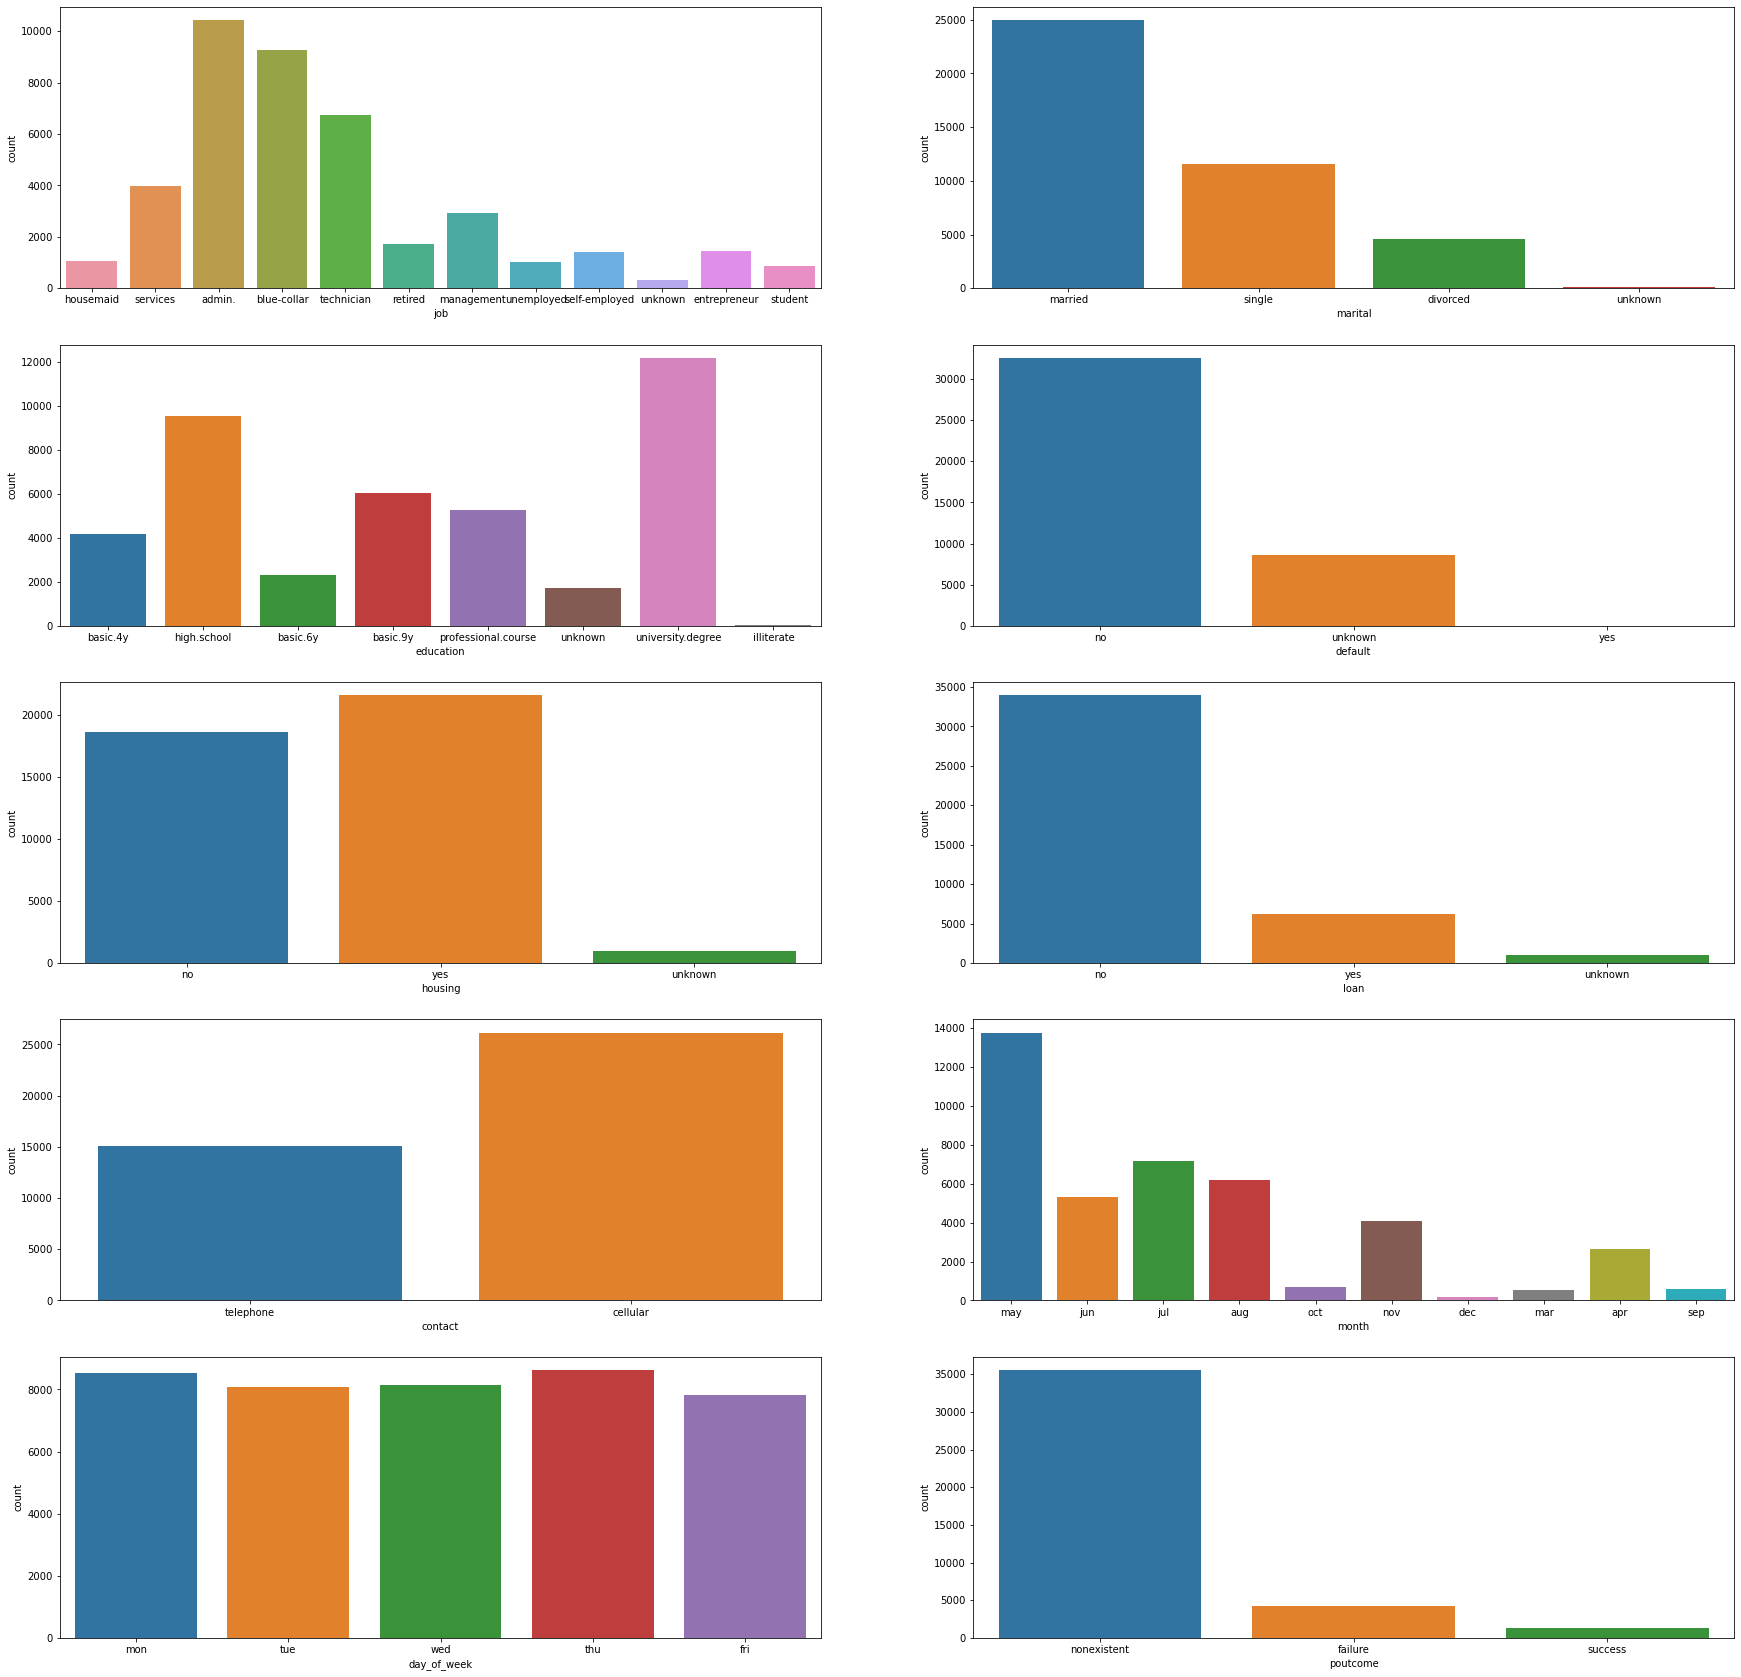

In [16]:
fig, axs = plt.subplots(nrows=5,ncols=2, figsize=(30,30))

sns.countplot(data=df, x='job', ax=axs[0,0])
sns.countplot(data=df, x='marital', ax=axs[0,1])
sns.countplot(data=df, x='education', ax=axs[1,0])
sns.countplot(data=df, x='default', ax=axs[1,1])
sns.countplot(data=df, x='housing', ax=axs[2,0])
sns.countplot(data=df, x='loan', ax=axs[2,1])
sns.countplot(data=df, x='contact', ax=axs[3,0])
sns.countplot(data=df, x='month', ax=axs[3,1])
sns.countplot(data=df, x='day_of_week', ax=axs[4,0])
sns.countplot(data=df, x='poutcome', ax=axs[4,1])


### Correlación entre las variables

<AxesSubplot:>

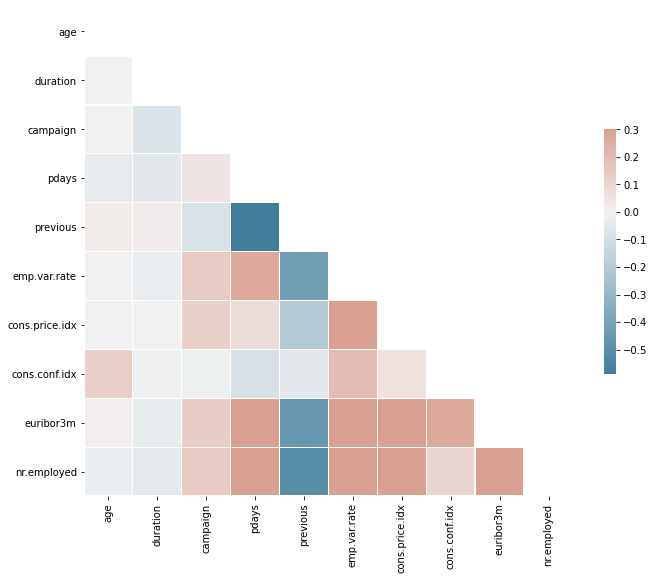

In [17]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Tratamiento y modificación de las variables

### Valores nulos
No se realiza ningún tratamiento, ya que, el dataset no presenta valores nulos.

### Outliers

In [20]:
from scipy.stats import zscore

# Elimacion de unicamente los outliers - df
def delete_outliers(df, cols):
    df = df.copy()
    temp = []
    df_clean = df.copy()

    for c in cols:
        z_scores = zscore(df_clean[c])
        abs_z_scores = np.abs(z_scores)
        filtered_entries = (abs_z_scores < 3)
        row_clean = df_clean[filtered_entries][c]
        temp.append([c, len(df_clean[c]), len(row_clean), len(df_clean[c]) - len(row_clean), df_clean[c].isna().sum() ])
        df_clean = df_clean[filtered_entries]
    temp = pd.DataFrame(temp, columns=["name", "count_values", "without_outliers", "count_outliers", "nan_count"])

    df_with_nan = df[cols][df[cols].isna().any(axis=1)]

    df_clean.merge(df_with_nan)

    return temp, df_clean

# columnas a analizar y eliminar outliers
temp, df = delete_outliers(df, ['duration', 'age', 'cons.conf.idx'] )

In [21]:
temp

,name,count_values,without_outliers,count_outliers,nan_count
0,duration,41188,40327,861,0
1,age,40327,39963,364,0
2,cons.conf.idx,39963,39963,0,0


### Distribuciones de las variables numéricas

#### Creación de la variable contactado
La variable "contactado", determina si el usuario fue previamente contactado o no. Esta conclusión se realizó, porque en la información de atributos dice que los usuarios con pdays = 999, no fueron contactados previamente.

<AxesSubplot:xlabel='contactado', ylabel='count'>

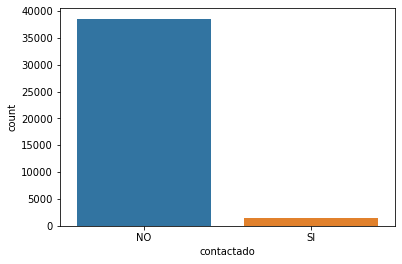

In [29]:
def get_contactado(x):
    if x >= 999:
        return 'NO'
    else:
        return 'SI'

df['contactado'] = df.apply(lambda x: get_contactado(x['pdays']), axis=1)
    
# Drop de columna pdays
df.drop('pdays', axis=1, inplace=True)

sns.countplot(data=df, x='contactado')

### Cardinalidad de las variables categóricas

#### Educacion

<AxesSubplot:xlabel='education', ylabel='count'>

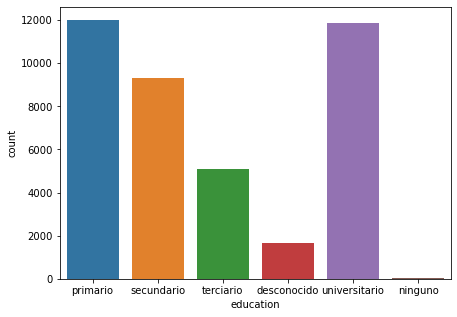

In [33]:
df.education.replace({'unknown': 'desconocido',
            'illiterate': 'ninguno',
            'basic.4y': 'primario',
           'basic.6y':'primario',
           'basic.9y': 'primario',
           'high.school':'secundario',
           'professional.course':'terciario',
           'university.degree':'universitario'}, inplace=True)

fig, axs = plt.subplots(figsize=(7,5))
sns.countplot(data=df, x='education')

#### Productos financieros

<AxesSubplot:xlabel='productos_financieros', ylabel='count'>

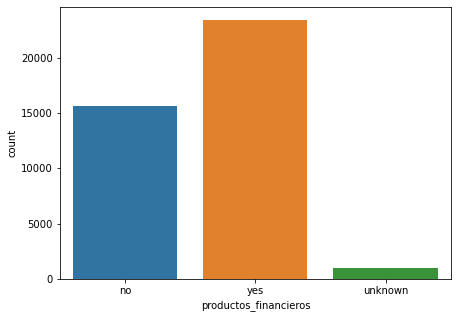

In [35]:
def productos_financieros(x):
    if x.loan == 'yes' or x.housing == 'yes':
        return 'yes'
    elif x.loan == 'unknown' or x.housing == 'unknown':
        return 'unknown'
    else:
        return 'no'
    
# Creamos esta columna para ver si el usuario adquirio productos financieros
df['productos_financieros'] = df.apply(lambda x: productos_financieros(x), axis=1)

# Drop de columnas loan y housing
df.drop(['loan', 'housing'], axis=1, inplace=True)

fig, axs = plt.subplots(figsize=(7,5))
sns.countplot(data=df, x='productos_financieros')

#### Dummeo de variables categoricas
Se dummean las variables categoricas para poder utilizar el modelo XGBoost, ya que, solamente acepta variables numericas.

In [37]:
df = pd.get_dummies(df)
print(df.head())

   age  duration  campaign  previous  emp.var.rate  cons.price.idx  \
0   56       261         1         0           1.1          93.994   
1   57       149         1         0           1.1          93.994   
2   37       226         1         0           1.1          93.994   
3   40       151         1         0           1.1          93.994   
4   56       307         1         0           1.1          93.994   

   cons.conf.idx  euribor3m  nr.employed  y  job_admin.  job_blue-collar  \
0          -36.4      4.857       5191.0  0           0                0   
1          -36.4      4.857       5191.0  0           0                0   
2          -36.4      4.857       5191.0  0           0                0   
3          -36.4      4.857       5191.0  0           1                0   
4          -36.4      4.857       5191.0  0           0                0   

   job_entrepreneur  job_housemaid  job_management  job_retired  \
0                 0              1               0     

### Correlacion entre variables

### Otras transformaciones

### Codificación del target

<AxesSubplot:xlabel='y', ylabel='count'>

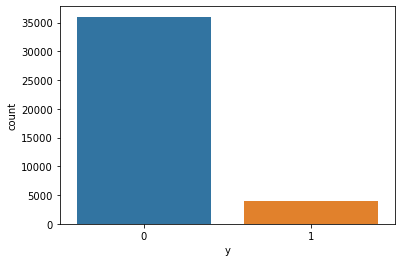

In [36]:
# Transformo la variable target para calcular P-Value
def factorize_y(x):
    if x == 'no':
        return 0
    else:
        return 1
    
df['y'] = df.apply(lambda x: factorize_y(x['y']), axis=1)

sns.countplot(data=df, x='y')

### Guardar el dataset final

In [38]:
df.to_csv('../data_preprocessed.txt', index=None, sep='|')

# Desbalanceo de clases

<AxesSubplot:xlabel='y', ylabel='count'>

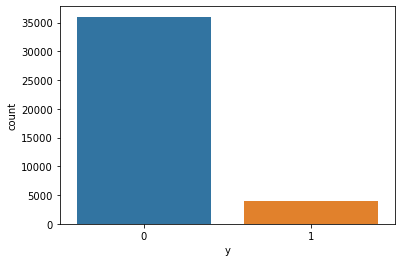

In [24]:
sns.countplot(data=df, x='y')

## Usar SMOTETomek para desbalanceo de clases

SMOTE (Synthetic Minority Oversampling Technique) es una tecnica de oversampling y crea muestras sintéticas nuevas de la clase minoritaria. Tomek es usado para quitar las muestras que se encuentran cerca de la frontera de las dos clases, y con ello se puede aumentar la separacion entre las dos clases.

In [25]:
# Dividir el dataset en X e y
y = df['y'].copy()
X = df.drop('y', axis=1).copy()

In [26]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42)
X, y = smt.fit_resample(X,y)

<AxesSubplot:xlabel='y', ylabel='count'>

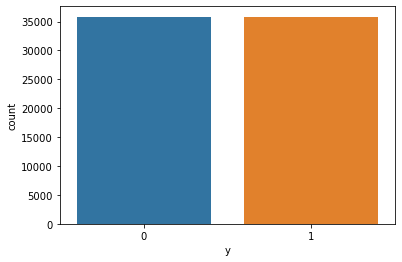

In [27]:
X['y'] = y
sns.countplot(data=X, x='y')

In [30]:
X.shape

(71680, 60)

# Guardado de archivo

In [31]:
# Guardamos los datos para empezar a modelar
X.to_csv('../data_preprocessed.txt', index=None, sep='|')